# Bank scoring project

### Victor Kovatsenko DST - 25

# Data input 

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [104]:
# Read data 
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

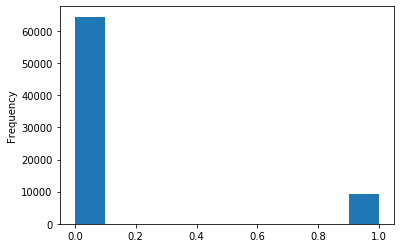

In [105]:
# Create histogram for 'default' 
data['default'].plot.hist()

We see disbalance in target variable. Number of defaults is around 7 times lower than non-defaults.

# Preprocessing

In [106]:
# Create function for numerical features analysis

def print_numerical(item_name, n_bins=100):
    
    '''This function creates 2 figures with boxplot and distribution plot as well as desriptive table to
        analyse numeric variables'''
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        
    # boxplot    
    data.boxplot(column=item_name, ax=axes[0])
    axes[0].set_title(item_name, fontsize=22)
    
    # distplot
    sns.distplot(data[item_name], bins=n_bins, kde=False, ax=axes[1], vertical=True)
    axes[1].set_title(item_name, fontsize=22)
    plt.xticks(rotation=45)
        
    # descriptive statistics
    print(pd.DataFrame(data[item_name].describe()).T, "\n")

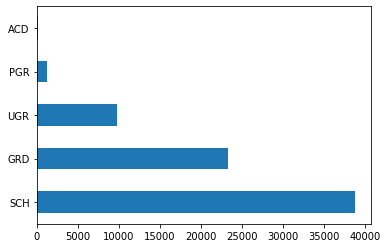

In [107]:
# The only one variable which has missedvalues is 'education'. Let's take a look on it
data['education'].value_counts().plot.barh()

In [108]:
# The number of missed values is not very big in total observations. So let's replacethem with most common type SCH
data['education'].fillna(value='SCH', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73799 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [109]:
# Take a look into the data
data.head(100000)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


There are some binary, category and date variables. It requires additional preprocessing

In [110]:
# Work with date. All data is from 2014, so information about year is not sufficient. 
from datetime import datetime
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

# Let's take a month when application was performed. It may be helpful because statistically customers take loans 
# more frequently in December and in Spring months when personal funds are usually not enough
data['app_date_month'] = data.app_date.dt.month
data = data.drop('app_date', axis=1)

In [111]:
data.head(10000)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_date_month
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,3
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,2
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32952,SCH,F,66,N,N,0,0,-1.758109,4,60,2,3,9000,4,1,N,0,2
9996,42762,SCH,F,35,N,N,0,0,-1.995989,1,60,2,3,15000,1,4,N,0,2
9997,48428,UGR,M,56,Y,Y,0,0,-2.215485,3,80,2,3,50000,4,1,N,0,2
9998,31171,GRD,M,29,Y,Y,0,1,-1.500865,1,50,1,2,75000,1,3,N,0,2


In [112]:
# Create lists of columns grouped by column type
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

       count       mean        std   min   25%   50%   75%   max
age  73799.0  39.280641  11.520378  21.0  30.0  37.0  48.0  72.0 

                   count      mean       std  min  25%  50%  75%   max
decline_app_cnt  73799.0  0.275749  0.804272  0.0  0.0  0.0  0.0  33.0 

          count          mean         std     min      25%      50%      75%  \
income  73799.0  41099.775417  46166.3224  1000.0  20000.0  30000.0  48000.0   

              max  
income  1000000.0   

                   count      mean       std  min  25%  50%  75%   max
bki_request_cnt  73799.0  2.000339  2.252073  0.0  0.0  1.0  3.0  53.0 

             count      mean       std       min       25%       50%  \
score_bki  73799.0 -1.904724  0.498231 -3.624586 -2.259534 -1.920823   

                75%       max  
score_bki -1.569831  0.199773   



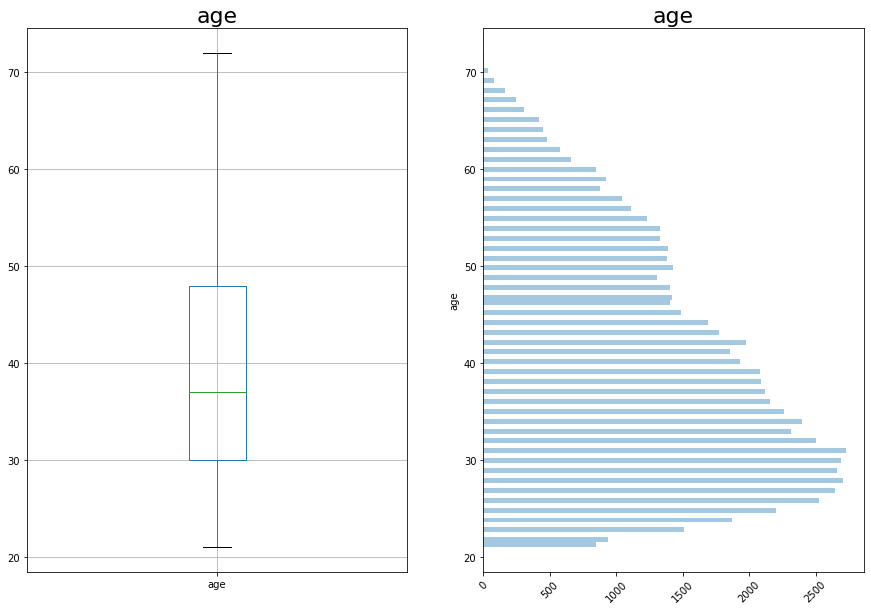

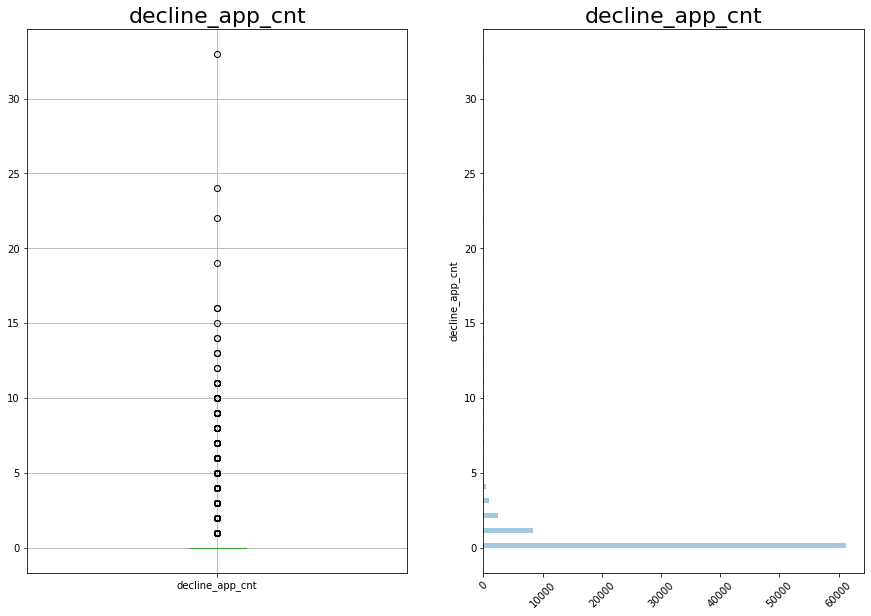

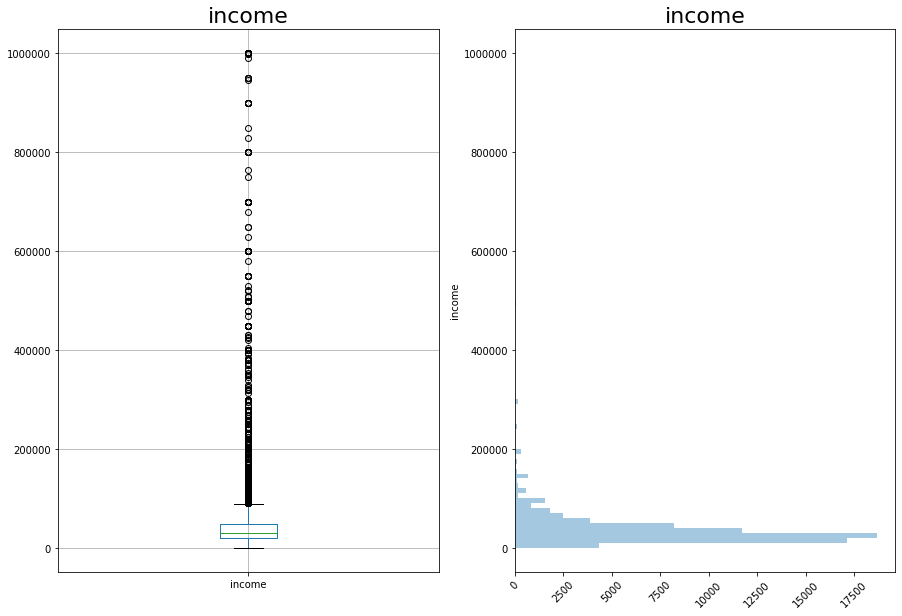

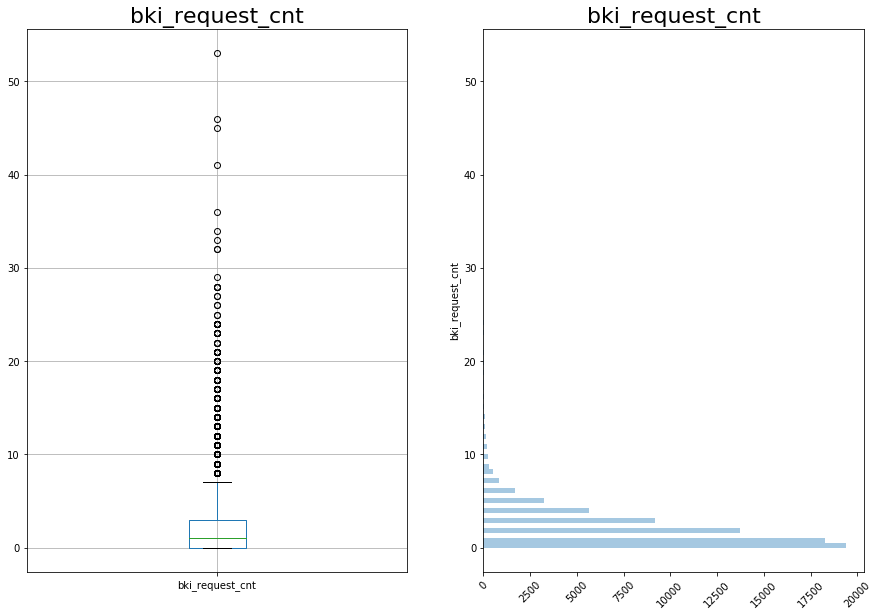

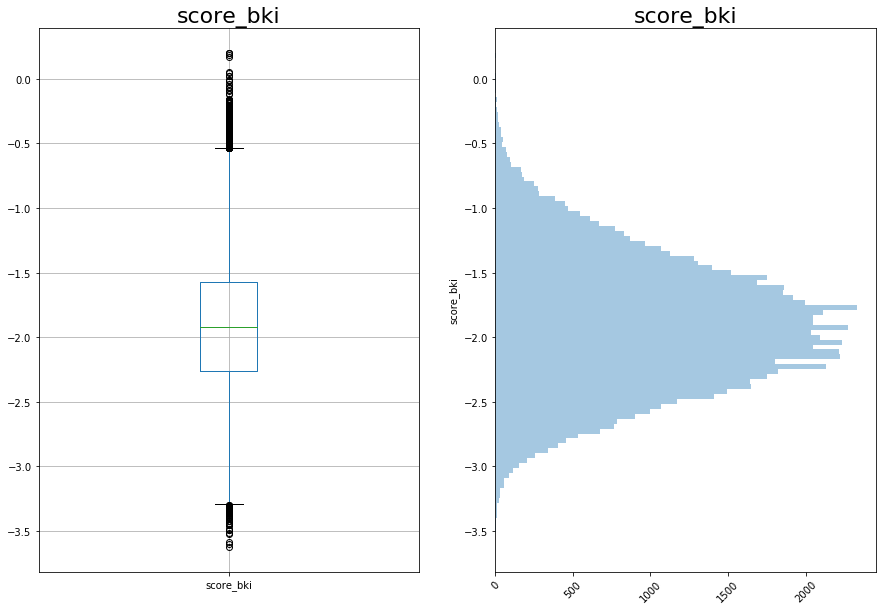

In [113]:
# Let's take a look on numeric columns
for i in num_cols:
    print_numerical(i)

Most variables (except score_bki) have heavy right tails, they should be normalized. 

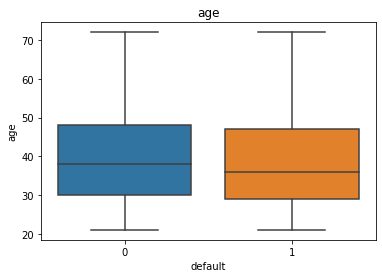

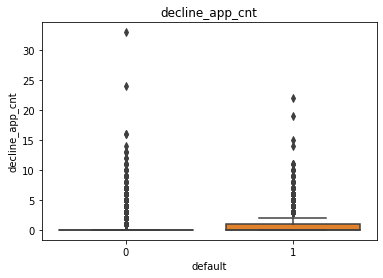

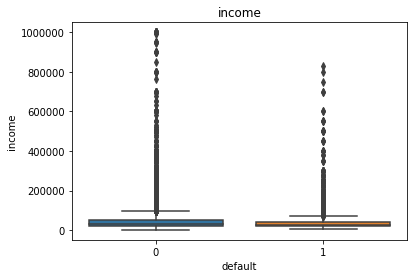

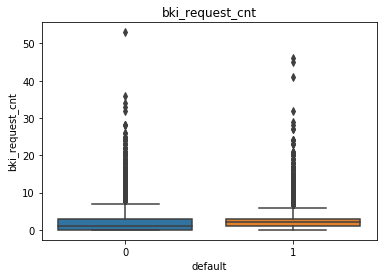

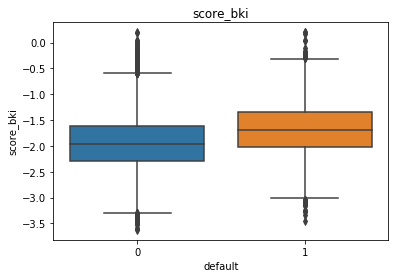

In [114]:
# Let's fix target variable (default) on X axis and take a closer look on numeric boxplots
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = i, data=data)
    plt.title(i)
    plt.show()

There are also many outliers which should be excluded. In general, defualt clients are younder have lower income and have more bki requests as well as declined applications.

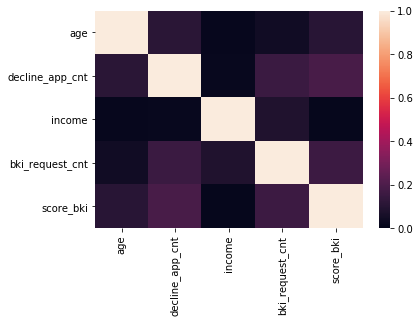

In [115]:
# Let's take a look on correlation within numeric columns
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

All variables has low correlation between each other which is good to avoid multicollinearity.

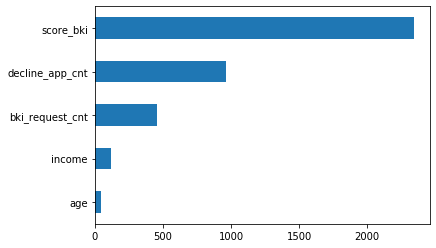

In [116]:
# General significancy of numeric variables 
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

As we see on the plot score_bkiis the most significant variable in our model. Age could be excluded in the future

In [117]:
# Work with binary variables. Assign numeric value
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Check with classes_
print(dict(enumerate(label_encoder.classes_)))

{0: 0, 1: 1}


In [118]:
# Significance of binary and categoric variables together

# Firstly, transform education in numeric format
ord_enc = OrdinalEncoder()
data['education'] = ord_enc.fit_transform(data[['education']])

In [119]:
data['education'].head(10)

0    3.0
1    3.0
2    3.0
3    3.0
4    1.0
5    3.0
6    3.0
7    3.0
8    3.0
9    4.0
Name: education, dtype: float64

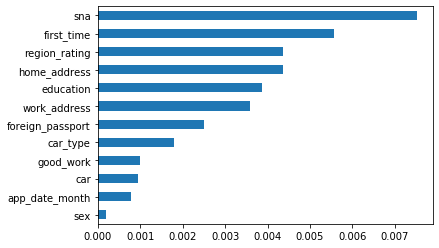

In [120]:
# Use mutual_info_classif to calculate significancy
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

As we can see sna is the most significant variable, sex, car, app_date_month, good_work are the less.

In [121]:
# Remove some binary and category variables
# data = data.drop(['good_work', 'car', 'app_date_month', 'sex'], axis=1)
# bin_cols = ['car_type', 'foreign_passport']
# cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']

In [122]:
# Let's take a look on current dataset
data.head(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_date_month
0,25905,3.0,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0,2
1,63161,3.0,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0,3
2,25887,3.0,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0,2
3,16222,3.0,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0,1
4,101655,1.0,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0,4
5,41415,3.0,1,27,1,0,0,1,-2.032257,0,50,1,1,15000,2,3,0,0,2
6,28436,3.0,1,39,0,0,0,0,-2.225004,0,60,1,2,28000,1,1,0,0,2
7,68769,3.0,0,39,0,0,0,0,-1.522739,1,50,2,3,45000,3,3,0,0,3
8,38424,3.0,0,50,1,0,1,0,-1.676061,0,50,1,1,30000,1,4,0,0,2
9,4496,4.0,0,54,0,0,0,0,-2.695176,1,50,2,3,24000,1,3,0,0,1


Some variables have high values. We also should remember about outliers. Category variable 'region_rating' can be devided by 10

In [123]:
# Devide region_rating by 10
data.region_rating = data.region_rating/10

In [124]:
# Take logarithms work with outliers
for i in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    data[i] = np.log(data[i] + 1)

       count       mean        std   min   25%   50%   75%   max
age  73799.0  39.280641  11.520378  21.0  30.0  37.0  48.0  72.0 

                   count      mean       std  min  25%  50%  75%       max
decline_app_cnt  73799.0  0.152451  0.362971  0.0  0.0  0.0  0.0  3.526361 

          count       mean       std       min       25%        50%  \
income  73799.0  10.345886  0.697702  6.908755  9.903538  10.308986   

              75%        max  
income  10.778977  13.815512   

                   count      mean       std  min  25%       50%       75%  \
bki_request_cnt  73799.0  0.878014  0.657881  0.0  0.0  0.693147  1.386294   

                      max  
bki_request_cnt  3.988984   

             count      mean       std       min       25%       50%  \
score_bki  73799.0 -1.904724  0.498231 -3.624586 -2.259534 -1.920823   

                75%       max  
score_bki -1.569831  0.199773   



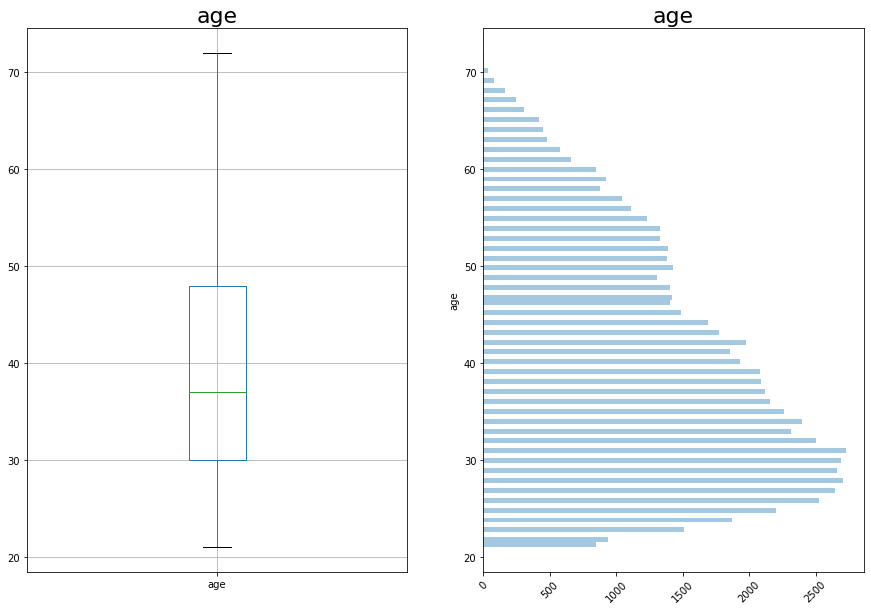

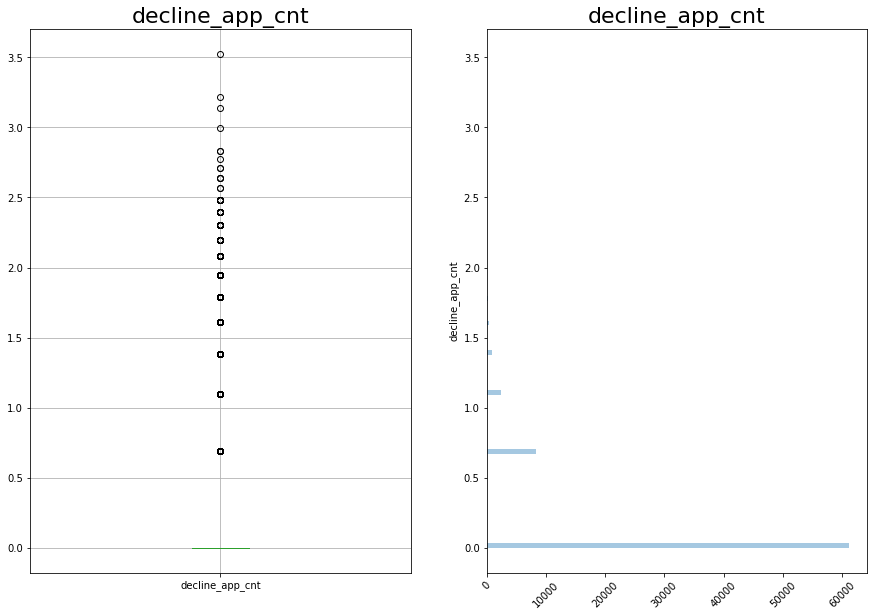

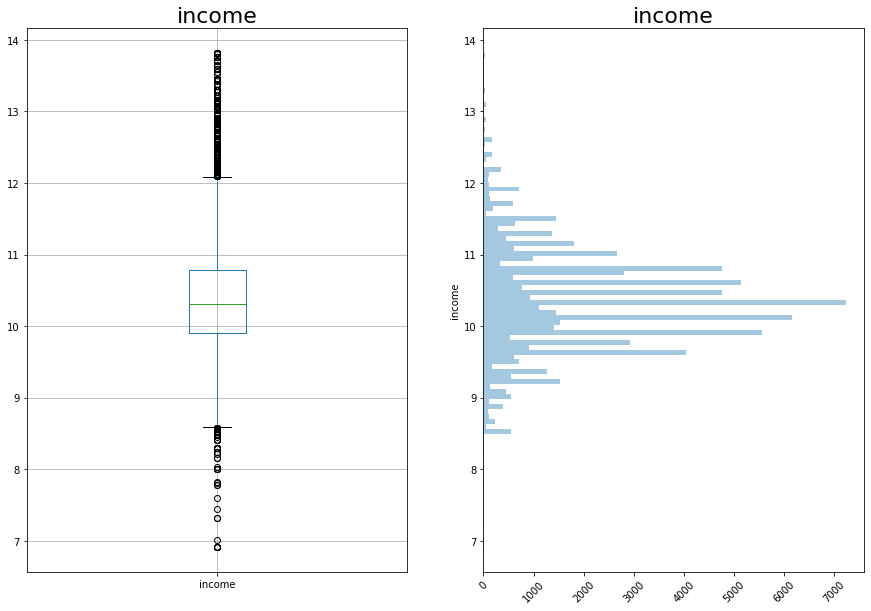

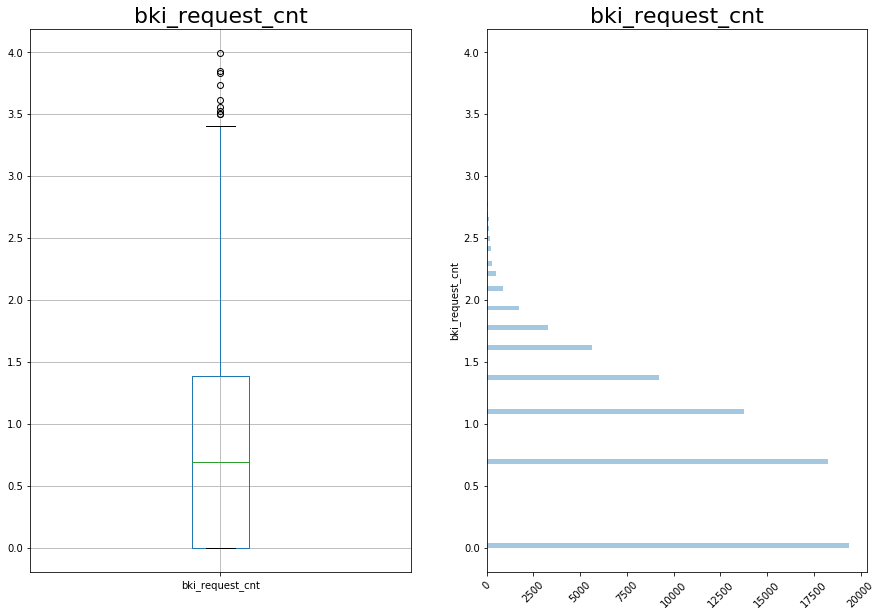

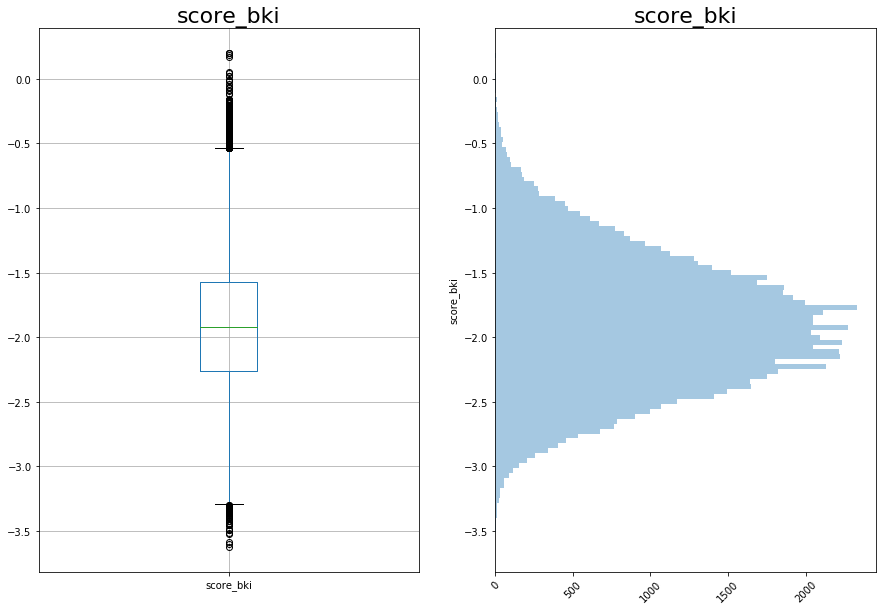

In [125]:
for i in num_cols:
    print_numerical(i)

In [126]:
# We still have many outliers in numeric columns. Let's use RobustScaler to normalize it
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)
data.head(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_date_month
0,25905,3.0,1,1.972115,1,1,-0.420012,0,-0.208799,-0.281005,5.0,1,2,-0.785016,4,1,0,0,2
1,63161,3.0,0,1.711705,0,0,-0.420012,0,0.747545,0.772607,5.0,2,3,-0.707526,4,1,0,0,3
2,25887,3.0,1,-1.239607,1,0,2.606733,0,0.996696,-0.281005,8.0,1,2,-0.052888,1,4,1,0,2
3,16222,3.0,0,1.190886,0,0,-0.420012,0,-0.306582,0.335319,5.0,2,3,-1.627419,1,3,0,0,1
4,101655,1.0,1,0.756869,0,0,-0.420012,1,1.324697,-0.281005,6.0,2,3,-0.052888,1,4,1,0,4
5,41415,3.0,1,-1.066000,1,0,-0.420012,1,-0.255975,-1.334617,5.0,1,1,-1.046319,2,3,0,0,2
6,28436,3.0,1,-0.024361,0,0,-0.420012,0,-0.642839,-1.334617,6.0,1,2,-0.151771,1,1,0,0,2
7,68769,3.0,0,-0.024361,0,0,-0.420012,0,0.766687,-0.281005,5.0,2,3,0.528244,3,3,0,0,3
8,38424,3.0,0,0.930476,1,0,1.489652,0,0.458952,-1.334617,5.0,1,1,-0.052888,1,4,0,0,2
9,4496,4.0,0,1.277689,0,0,-0.420012,0,-1.586528,-0.281005,5.0,2,3,-0.372705,1,3,0,0,1


In [127]:
# Remove some less significant or correlated varibles: age, bki_request_cnt, sex and car from X
bin_cols = ['car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month', 'region_rating']
num_cols = ['decline_app_cnt', 'income', 'score_bki']

In [128]:
# Transform category variables into dummies with OneHotEncoder
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [129]:
# Create X, Y
X = np.hstack([data[bin_cols + num_cols].values, X_cat])
Y = data['default'].values

# Model

In [130]:
# Create functions for working with model

# Train/test splitting
def splitting(X, Y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

# Roc AUC curve
def print_roc_curve(model):
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


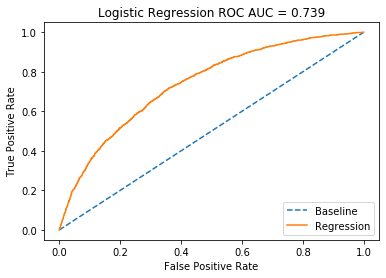

In [131]:
# Create model and roc_curve
X_train, X_test, y_train, y_test = splitting(X, Y)

# Here we can fit model with X because we used for analysis train dataset only
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

print_roc_curve(model)

We got model with auc score = 0.739 which is good for first approximation. Now the model will be improved, working with regularization

In [132]:
# Let's take a look on confusion matrix
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

41 58
1786 12875


We see that model works good for negative (no default) values, but bad for positive (default) values. It may be related to highly imbalanced dataset.

In [ ]:
# Regularization

model = LogisticRegression(random_state=42)
iter_max = 100
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
print(best_model)

In [ ]:
print_roc_curve(best_model)

In [ ]:
# Let's take a look on confusion matrix
y_pred = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

We improved model in terms of default clients prediction which is more crucial for bank scoring than increased number of false positive values. This scoring model is a bit conservative, but I think there were obtained good results.

In [ ]:
# Combine data preprocessing in function for test.csv

def data_preprocessing_test(data):
    #Replace missed values in education and work with datetime
    data['education'].fillna(value='SCH', inplace=True)
    data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')
    data['app_date_month'] = data.app_date.dt.month
    data = data.drop('app_date', axis=1)
    
    # Create column lists
    num_cols = ['age', 'decline_app_cnt','bki_request_cnt', 'income', 'score_bki']
    bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
    cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month', 'region_rating']
    
    # Work with binary variables. Assign numeric value
    label_encoder = LabelEncoder()

    for column in bin_cols:
        data[column] = label_encoder.fit_transform(data[column])
    
    # Firstly, transform education in numeric format
    ord_enc = OrdinalEncoder()
    data['education'] = ord_enc.fit_transform(data[['education']])
    
    # Devide region_rating by 10
    data.region_rating = data.region_rating/10
    
    # Apply RobustScaler
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols].values)
    
    # Remove some less significant varibles: age, sex and car from X
    bin_cols = ['car_type', 'foreign_passport', 'good_work']
    cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'app_date_month', 'region_rating']
    num_cols = ['decline_app_cnt', 'income', 'score_bki']
        
    # Transform category variables into dummies with OneHotEncoder
    X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
    
    # Create X_test
    X_test = np.hstack([data[bin_cols + num_cols].values, X_cat])
    
    return X_test

In [ ]:
# Read test data
test_data = pd.read_csv('test.csv')

In [ ]:
# Apply data preprocessing
X_test = data_preprocessing_test(test_data)

In [ ]:
# Make submissions
predict_submission = best_model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(test_data.client_id)
submit['default']=predict_submission
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

P.S. Интересно, что чем меньше у меня тут получается AUC score тем выше результат на каггле... Изначально был 0,745 и рейтинг на каглле 0,71 Теперь метрика ниже а результат на каггл выше.